In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import cv2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [4]:
tqdm.pandas()

C:\Users\admin\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
train_df = pd.read_csv(r"C:\Users\admin\fairface_label_train.csv")
test_df = pd.read_csv(r"C:\Users\admin\fairface_label_val.csv")

for x in range(1000, 86744):
    train_df.drop(index=[x], inplace=True)
for x in range(1000, 10954):
    test_df.drop(index=[x], inplace=True)

In [6]:
print("trainset consists of ",train_df.shape)
print("test set consist of ",test_df.shape)

trainset consists of  (1000, 5)
test set consist of  (1000, 5)


In [7]:
train_df['file'] = 'FairFace/'+train_df['file']
test_df['file'] = 'FairFace/'+test_df['file']

In [8]:
train_df.head()

,file,age,gender,race,service_test
0,FairFace/train/1.jpg,50-59,Male,East Asian,True
1,FairFace/train/2.jpg,30-39,Female,Indian,False
2,FairFace/train/3.jpg,3-9,Female,Black,False
3,FairFace/train/4.jpg,20-29,Female,Indian,True
4,FairFace/train/5.jpg,20-29,Female,Indian,True


In [9]:
100*train_df.groupby(['race']).count()[['file']]/train_df.groupby(['race']).count()[['file']].sum()

,file
race,
Black,14.7
East Asian,12.8
Indian,14.0
Latino_Hispanic,17.2
Middle Eastern,9.6
Southeast Asian,11.9
White,19.8


In [10]:
idx = train_df[(train_df['race'] == 'East Asian') | (train_df['race'] == 'Southeast Asian')].index
train_df.loc[idx, 'race'] = 'Asian'

idx = test_df[(test_df['race'] == 'East Asian') | (test_df['race'] == 'Southeast Asian')].index
test_df.loc[idx, 'race'] = 'Asian'

In [11]:
100*train_df.groupby(['race']).count()[['file']]/train_df.groupby(['race']).count()[['file']].sum()

,file
race,
Asian,24.7
Black,14.7
Indian,14.0
Latino_Hispanic,17.2
Middle Eastern,9.6
White,19.8


In [12]:
target_size = (224, 224)

def getImagePixels(file):
    #print(file)
    img = image.load_img(file, grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x

In [13]:
train_df['pixels'] = train_df['file'].progress_apply(getImagePixels)
test_df['pixels'] = test_df['file'].progress_apply(getImagePixels)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.85it/s]


In [14]:
train_df.head()

,file,age,gender,race,service_test,pixels
0,FairFace/train/1.jpg,50-59,Male,Asian,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,FairFace/train/2.jpg,30-39,Female,Indian,False,"[137.0, 128.0, 71.0, 133.0, 124.0, 67.0, 128.0..."
2,FairFace/train/3.jpg,3-9,Female,Black,False,"[172.0, 106.0, 82.0, 159.0, 95.0, 70.0, 152.0,..."
3,FairFace/train/4.jpg,20-29,Female,Indian,True,"[37.0, 48.0, 44.0, 39.0, 50.0, 46.0, 37.0, 48...."
4,FairFace/train/5.jpg,20-29,Female,Indian,True,"[171.0, 123.0, 59.0, 177.0, 116.0, 51.0, 195.0..."


In [15]:
train_features = []; test_features = []

for i in range(0, train_df.shape[0]):
    train_features.append(train_df['pixels'].values[i])

for i in range(0, test_df.shape[0]):
    test_features.append(test_df['pixels'].values[i])

In [16]:
tic = time.time()

train_features = np.array(train_features)
train_features = train_features.reshape(train_features.shape[0], 224, 224, 3)

test_features = np.array(test_features)
test_features = test_features.reshape(test_features.shape[0], 224, 224, 3)

toc = time.time()

print("converted to numpy in ",toc-tic,"seconds")

converted to numpy in  2.219064950942993 seconds


In [17]:
tic = time.time()

train_features = train_features / 255
test_features = test_features / 255

toc = time.time()

print("converted to numpy in ",toc-tic,"seconds")

converted to numpy in  9.914621353149414 seconds


In [18]:
train_label = train_df[['race']]
test_label = test_df[['race']]

In [19]:
races = train_df['race'].unique()

In [20]:
for j in range(len(races)): #label encoding
    current_race = races[j]
    print("replacing ",current_race," to ", j+1)
    train_label['race'] = train_label['race'].replace(current_race, str(j+1))
    test_label['race'] = test_label['race'].replace(current_race, str(j+1))

train_label = train_label.astype({'race': 'int32'})
test_label = test_label.astype({'race': 'int32'})

replacing  Asian  to  1
replacing  Indian  to  2
replacing  Black  to  3
replacing  White  to  4
replacing  Middle Eastern  to  5
replacing  Latino_Hispanic  to  6


<ipython-input-20-8c1856772b82>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_label['race'] = train_label['race'].replace(current_race, str(j+1))
<ipython-input-20-8c1856772b82>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_label['race'] = test_label['race'].replace(current_race, str(j+1))


In [21]:
train_label.head()

,race
0,1
1,2
2,3
3,2
4,2


In [22]:
train_target = pd.get_dummies(train_label['race'], prefix='race')
test_target = pd.get_dummies(test_label['race'], prefix='race')

In [23]:
train_target.head()

,race_1,race_2,race_3,race_4,race_5,race_6
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [24]:
train_x, val_x, train_y, val_y = train_test_split(train_features, train_target.values
                                        , test_size=0.12, random_state=17)

In [25]:
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

In [26]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [27]:
model.load_weights('vgg_face_weights.h5')

In [28]:
num_of_classes = 6 #len(races)

In [29]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(num_of_classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

race_model = Model(inputs=model.input, outputs=base_model_output)

In [30]:
race_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  , metrics=['accuracy']
                 )

In [31]:
race_model.load_weights('race_model_single_batch.h5')

In [32]:
checkpointer = ModelCheckpoint(
    filepath='race_model_single_batch.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [33]:
patience = 3

In [34]:
val_scores = []; train_scores = []

In [51]:
enableBatch = True

epochs = 10

if enableBatch != True:
    early_stop = EarlyStopping(monitor='val_loss', patience=patience) 
    
    score = race_model.fit(
        train_x, train_y
        , epochs=epochs
        , validation_data=(val_x, val_y)
        , callbacks=[checkpointer, early_stop]
    )
else:
    batch_size = pow(2, 6)
    last_improvement = 0
    best_iteration = 0
    
    loss = 1000 #initialize as a large value
    
    for i in range(0, epochs):
        
        print("Epoch ", i, ". ", end='')
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = race_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(val_x, val_y)
            , callbacks=[checkpointer]
        )
        
        val_loss = score.history['val_loss'][0]
        train_loss = score.history['loss'][0]
        
        val_scores.append(val_loss)
        train_scores.append(train_loss)
        
        #--------------------------------
        
        if val_loss < loss:
            loss = val_loss * 1
            last_improvement = 0
            best_iteration = i * 1
        else:
            last_improvement = last_improvement + 1
            print("try to decrease val loss for ",patience - last_improvement," epochs more")
        
        #--------------------------------
        
        if last_improvement == patience:
            print("there is no loss decrease in validation for ",patience," epochs. early stopped")
            break

1/2 [==============>...............] - ETA: 1:00 - loss: 2.0002 - accuracy: 0.3125

KeyboardInterrupt: 

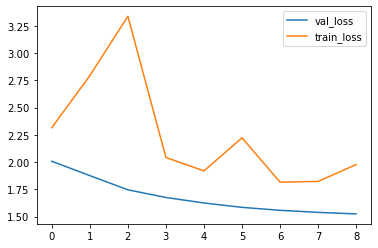

In [36]:
if enableBatch != True:
    plt.plot(score.history['val_loss'], label='val_loss')
    plt.plot(score.history['loss'], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()
else:
    plt.plot(val_scores[0:best_iteration], label='val_loss')
    plt.plot(train_scores[0:best_iteration], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()

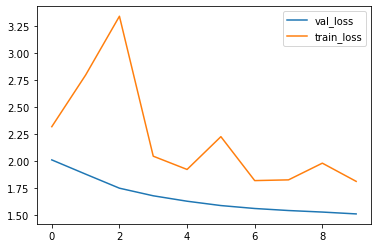

In [37]:
if enableBatch != True:
    plt.plot(score.history['val_loss'][0:best_iteration], label='val_loss')
    plt.plot(score.history['loss'][0:best_iteration], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()
else:
    plt.plot(val_scores[0:best_iteration+1], label='val_loss')
    plt.plot(train_scores[0:best_iteration+1], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()

In [55]:
#restore the best weights
#from keras.models import load_model
race_model = load_model("race_model_single_batch.hdf5")

race_model.save_weights('race_model_single_batch.h5')

In [39]:
test_perf = race_model.evaluate(test_features, test_target.values, verbose=1)
print(test_perf)

32/32 [==============================] - 212s 7s/step - loss: 1.4684 - accuracy: 0.4750
[1.4683918952941895, 0.4749999940395355]


In [40]:
validation_perf = race_model.evaluate(val_x, val_y, verbose=1)
print(validation_perf)

4/4 [==============================] - 24s 6s/step - loss: 1.5070 - accuracy: 0.4167
[1.506988286972046, 0.4166666567325592]


In [53]:
#Check model is robust
print(abs(validation_perf[0] - test_perf[0]) < 0.01)
print(abs(validation_perf[0] - test_perf[0]))

False
0.038596391677856445


In [54]:
predictions = race_model.predict(test_features)
print(type(predictions))

numpy.ndarray

17
Actual:  White
Predicted:  White


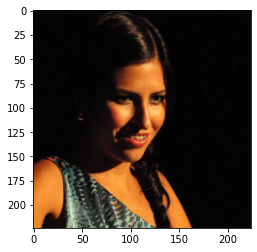

----------------------
33
Actual:  Asian
Predicted:  Asian


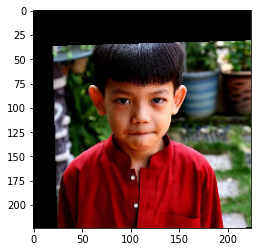

----------------------
83
Actual:  Asian
Predicted:  Asian


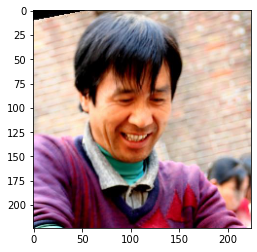

----------------------
109
Actual:  Indian
Predicted:  Indian


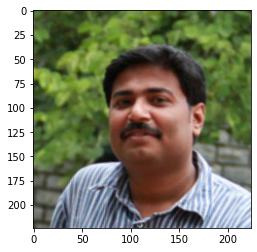

----------------------
124
Actual:  Black
Predicted:  Asian


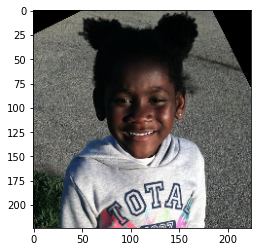

----------------------
203
Actual:  Indian
Predicted:  Latino_Hispanic


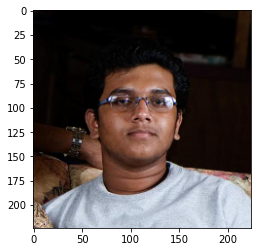

----------------------
235
Actual:  Latino_Hispanic
Predicted:  Asian


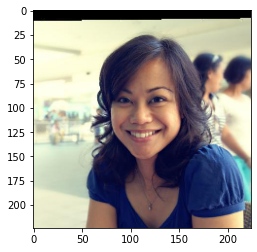

----------------------
237
Actual:  Asian
Predicted:  White


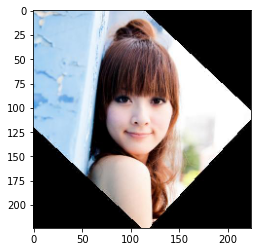

----------------------
339
Actual:  Black
Predicted:  Asian


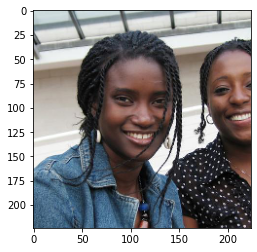

----------------------
375
Actual:  Latino_Hispanic
Predicted:  White


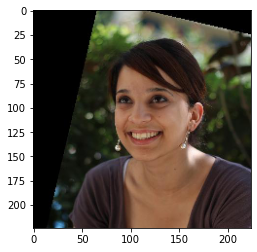

----------------------
413
Actual:  White
Predicted:  White


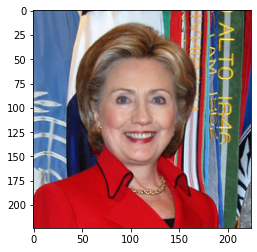

----------------------
447
Actual:  White
Predicted:  Middle Eastern


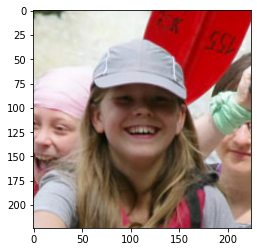

----------------------
470
Actual:  Latino_Hispanic
Predicted:  Asian


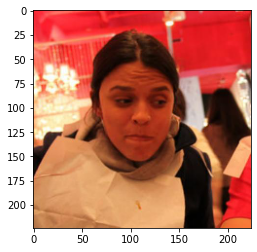

----------------------
573
Actual:  White
Predicted:  White


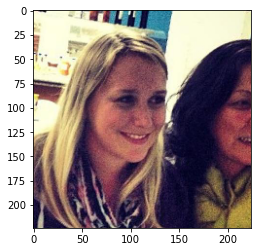

----------------------
609
Actual:  Asian
Predicted:  Asian


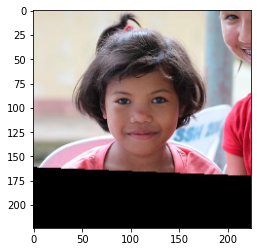

----------------------
638
Actual:  Middle Eastern
Predicted:  Asian


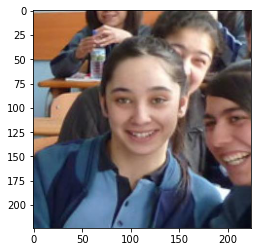

----------------------
649
Actual:  White
Predicted:  White


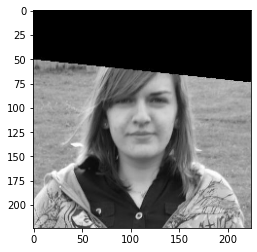

----------------------
718
Actual:  Middle Eastern
Predicted:  Asian


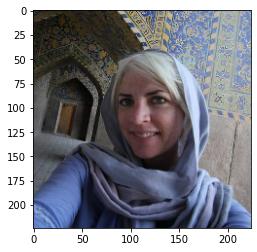

----------------------
723
Actual:  White
Predicted:  Asian


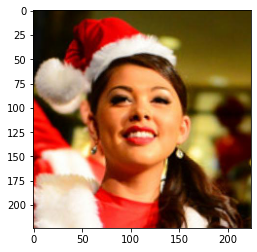

----------------------
750
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


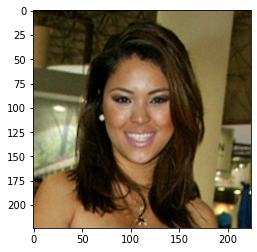

----------------------
758
Actual:  Latino_Hispanic
Predicted:  Indian


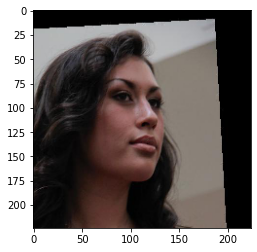

----------------------
762
Actual:  Black
Predicted:  Black


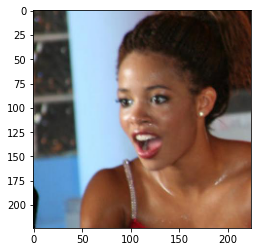

----------------------
817
Actual:  Asian
Predicted:  Asian


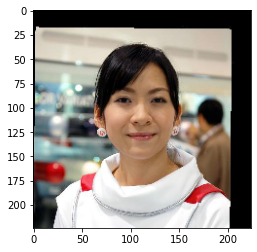

----------------------
875
Actual:  Latino_Hispanic
Predicted:  Asian


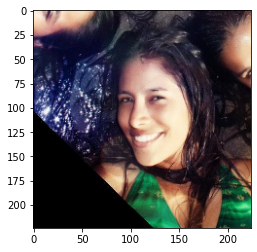

----------------------
899
Actual:  Indian
Predicted:  Indian


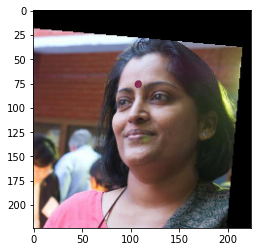

----------------------
913
Actual:  Black
Predicted:  Black


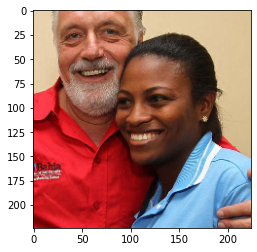

----------------------
992
Actual:  Latino_Hispanic
Predicted:  Latino_Hispanic


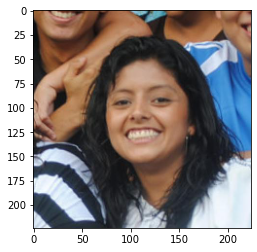

----------------------


In [43]:
prediction_classes = []; actual_classes = []

for i in range(0, predictions.shape[0]):
    prediction = np.argmax(predictions[i])
    prediction_classes.append(races[prediction])
    actual = np.argmax(test_target.values[i])
    actual_classes.append(races[actual])
    
    if i in [
        375, 470, 750, 758, 875, 992, 1061, 2181, 2255, 4725, 4944 #latino
        , 124, 339, 762, 913, 1340, 1363, 2205 #black
        , 33, 83, 237, 609, 817, 1223, 1377 #asian
        , 109, 203, 899, 1094, 1180, 1250, 1395, 1556 #indian
        , 638, 718, 1088, 1460, 4396, 4477 #middle eastern
        , 413, 447, 573, 649, 723, 1258, 1274, 1430, 1485 #white
        , 17, 235, #misclassified
    ]:
        print(i)
        print("Actual: ",races[actual])
        print("Predicted: ",races[prediction])
        
        img = (test_df.iloc[i]['pixels'].reshape([224, 224, 3])) / 255
        plt.imshow(img)
        plt.show()
        print("----------------------")

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [45]:
cm = confusion_matrix(actual_classes, prediction_classes)

In [46]:
cm

array([[217,   5,   5,  18,   4,  11],
       [ 79,  67,   7,  12,   4,   4],
       [ 50,   7,  23,  20,   9,   9],
       [ 45,   3,  10,  46,  18,  17],
       [ 38,   1,  12,  14,  38,  19],
       [ 55,   1,   1,  22,  25,  84]], dtype=int64)

In [47]:
df_cm = pd.DataFrame(cm, index=races, columns=races)

<AxesSubplot:>

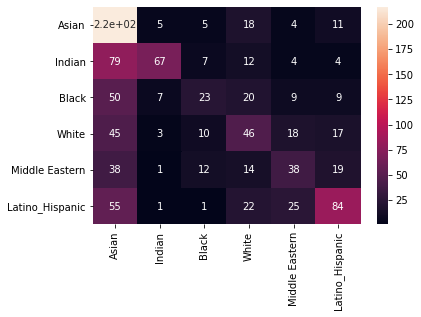

In [48]:
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})

In [49]:
races = ['Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic']

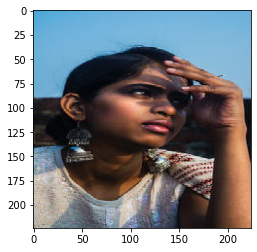

Prediction:  Latino_Hispanic
---------------------------


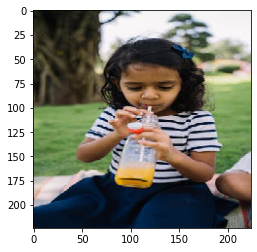

Prediction:  Asian
---------------------------


In [59]:
demo_set = ['indian girls13.jpg', 'indian girls23.jpg']

for file in demo_set:
    path = '%s' % (file) 
    img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
    img = image.img_to_array(img).reshape(1, -1)[0]
    img = img.reshape(224, 224, 3)
    img = img / 255
    
    plt.imshow(img)
    plt.show()
    
    img = np.expand_dims(img, axis=0) 

    prediction_proba = race_model.predict(img)

    print("Prediction: ",races[np.argmax(prediction_proba)])
    print("---------------------------")